# ISS Projekt (24/25)
## Hugo Bohácsek
### xbohach00

In [ ]:
%%capture
!pip install fastdtw
# needed
import os
import re
import glob
import soundfile as sf
from IPython.display import Audio
from IPython.display import display
# recommended ...
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, ifft, fftfreq
import scipy.io
import matplotlib.pyplot as plt
import numpy as np

import librosa
import librosa.display
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw


In [ ]:
%%capture
# read the file - change login to YOUR login
login = "xbohach00"
zip_file = login + ".zip"
assignment_file = "https://www.fit.vut.cz/study/course/ISS/public/proj2024-25/personal/" + zip_file
!wget $assignment_file
!unzip -o $zip_file


In [ ]:
# load the data
# references will be in ref_signals, reference labels in ref_labels, reference count in N_ref.
# tests  will be in test_signals, test labels in test_labels, test count in N_test.
def get_signals(labs):
    signals = []
    N = len(labs)
    for car in labs:
      filename = login + "/" + car + ".wav"
      s, Fs = sf.read(filename)
      signals.append(s)
    return signals, N, Fs

def play_signals(signals, Fs):
  for signal in signals:
    display(Audio(signal, rate=Fs))

files = glob.glob(login + "/*.wav")
names = [re.sub(login + "/", "", s) for s in files]
labels = [re.sub(".wav", "",s) for s in names]

r = re.compile("^test_");  test_labels = list(filter(r.match, labels))
test_signals, N_test, Fs = get_signals(test_labels)

r = re.compile("(?!^test_)");  ref_labels = list(filter(r.match, labels))
ref_signals, N_ref, Fs = get_signals(ref_labels)


Pre moje riešenie som zvolil prístup extrahovania charakteristických čŕt zvuku pomocou MFCC (Mel-frequency cepstral coefficients) a následný výpočet ich odlišnosti pomocou DTW - euklidovskej vzdialenosti.

**1) Prečo práve MFCC?**<br>
MFCC extrahuje spektrálne vlastnosti signálu. Vďaka tomuto je táto metóda "odolná" voči šumu - zmierňuje jeho efekt. V malých časových oknách (ako aj 1s) vie veľmi dobre zachytiť dynamické zmeny zvuku a zohľadňuje fungovanie ľudského sluchu.

**2) Prečo práve DTW s využitím euklidovskej vzdialenosti?**<br>
Euklidovská vzdialenosť je citlivejšia pri väčších rozdieloch v signáloch, čo sa nám hodí pretože tieto odchýlky sú významné. Je vhodná pre kontinuálne signály, a neignoruje veľkosť vektorov (ako pri kosínusovej podobnosti).<br>
Má však aj nevýhody, ktoré sú však z veľkej časti odstránené prvotným priechodom signálov MFCC. Hlavnou redukovanou nevýhodou je práve citlivosť na šum.

**Moje referenčné signály sú žiaľ veľmi nekvalitné. Konkrétne "Fiat_Panda_Drive", ktoré zvyšuje otáčky a "BMW_318i_Drive", ktoré znie akoby narážalo na obmedzovač otáčok??? Preto prosím spustite môj projekt aj s loginom "xdubnis00"-môj spolužiak, ktorý má dobré nahrávky. Vopred ďakujem :)**


Moje priradenia signálov je možné vidieť tu:



In [ ]:

ref_mfccs = [librosa.feature.mfcc(y=signal, sr=16000, n_mfcc=13) for signal in ref_signals]

test_mfccs = [librosa.feature.mfcc(y=signal, sr=16000, n_mfcc=13) for signal in test_signals]

dist = np.zeros((len(test_signals), len(ref_signals)))

for i, test_mfcc in enumerate(test_mfccs):
    for j, ref_mfcc in enumerate(ref_mfccs):
        dist[i, j], _ = fastdtw(test_mfcc.T, ref_mfcc.T, dist=euclidean)

result = []
for i, distances in enumerate(dist):
    min_distance_idx = np.argmin(distances)
    min_distance = distances[min_distance_idx]

    result.append((test_labels[i], ref_labels[min_distance_idx], min_distance))

for test_label, ref_label, distance in result:
    print(f"Signál {test_label} patrí referenčnému signálu {ref_label}. (Ich vzdialenosť: {distance})")

Signál test_k patrí referenčnému signálu Subaru_Forester_Drive. (Ich vzdialenosť: 2709.708743522514)
Signál test_s patrí referenčnému signálu Subaru_Forester_Drive. (Ich vzdialenosť: 4141.758672775156)
Signál test_l patrí referenčnému signálu Subaru_Forester_Drive. (Ich vzdialenosť: 2504.801402236778)
Signál test_o patrí referenčnému signálu VW_Polo_Drive. (Ich vzdialenosť: 2528.121230603143)


Následujú grafy vlnového priebehu, spektrogramu a MFCC pre jednotlivé signály

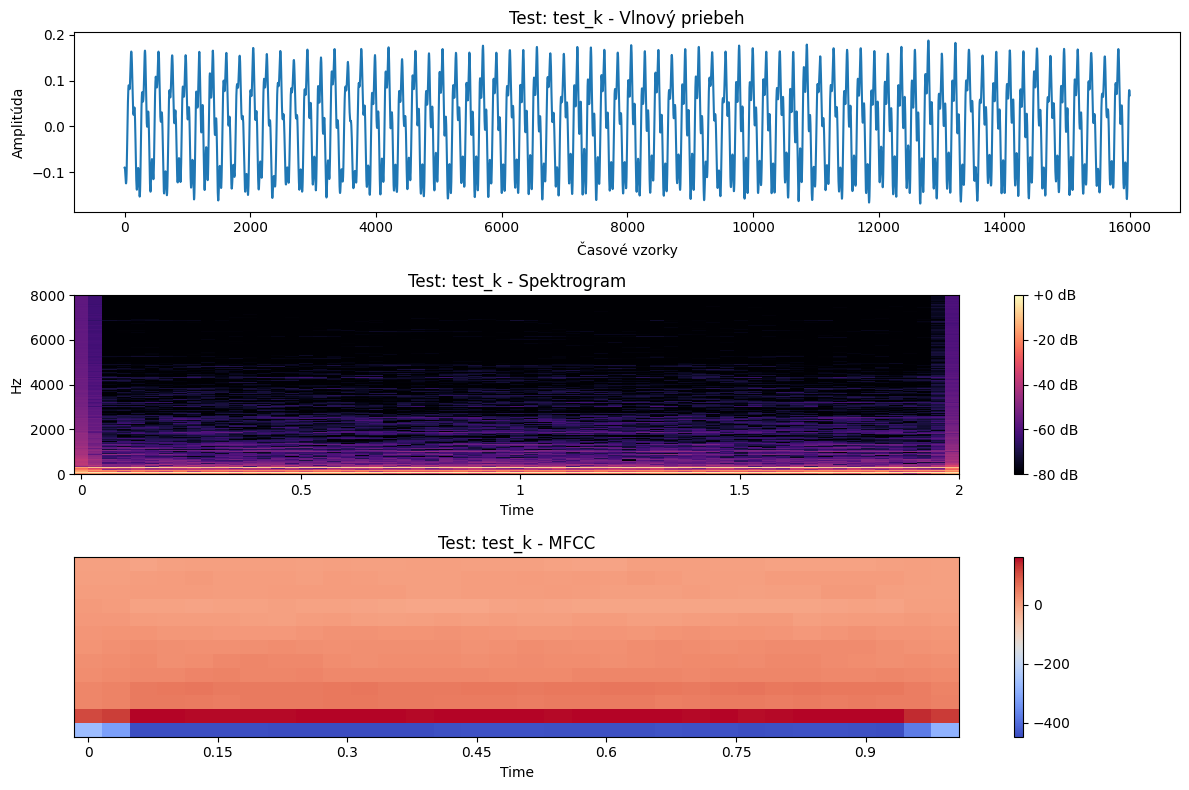

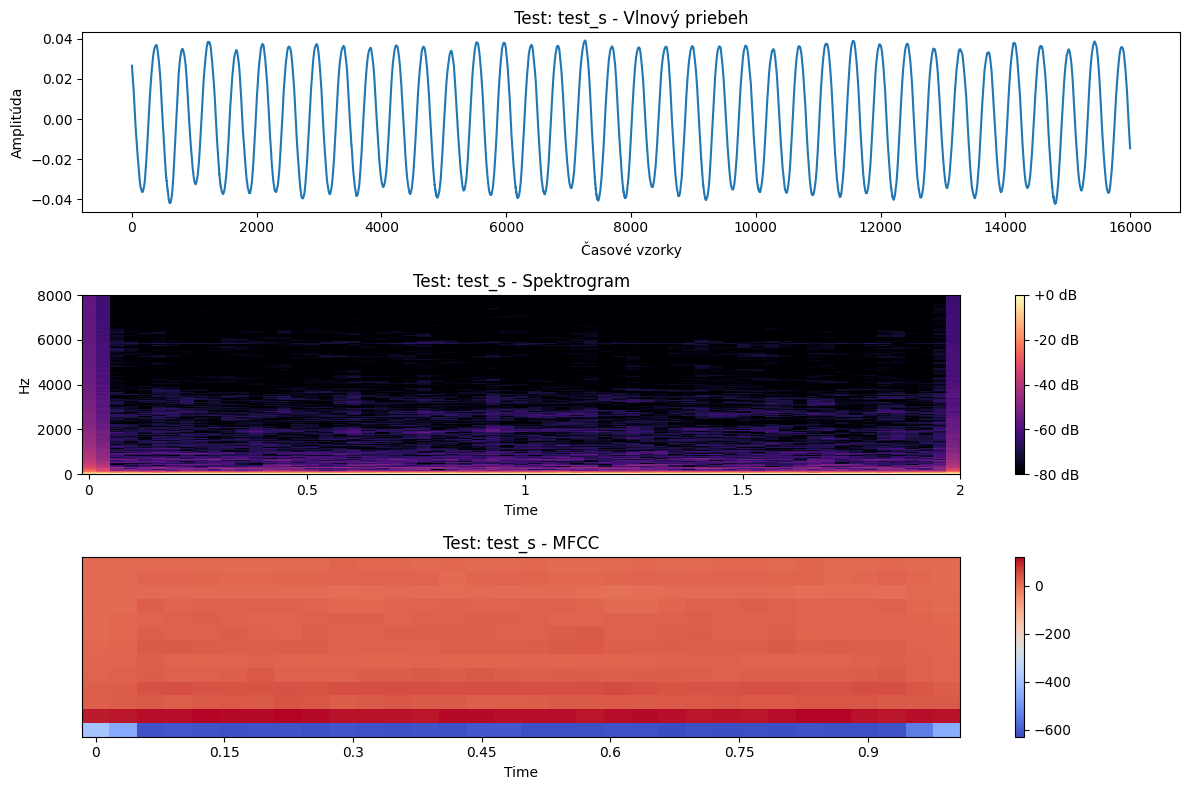

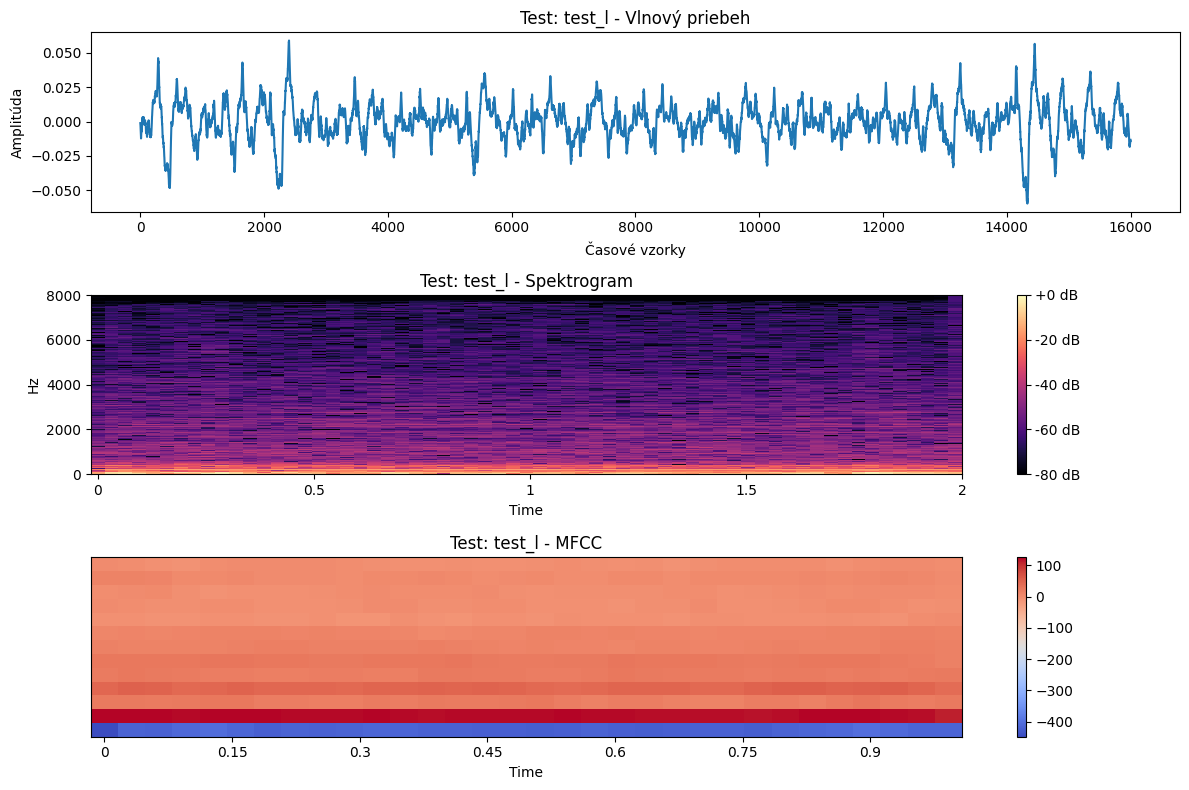

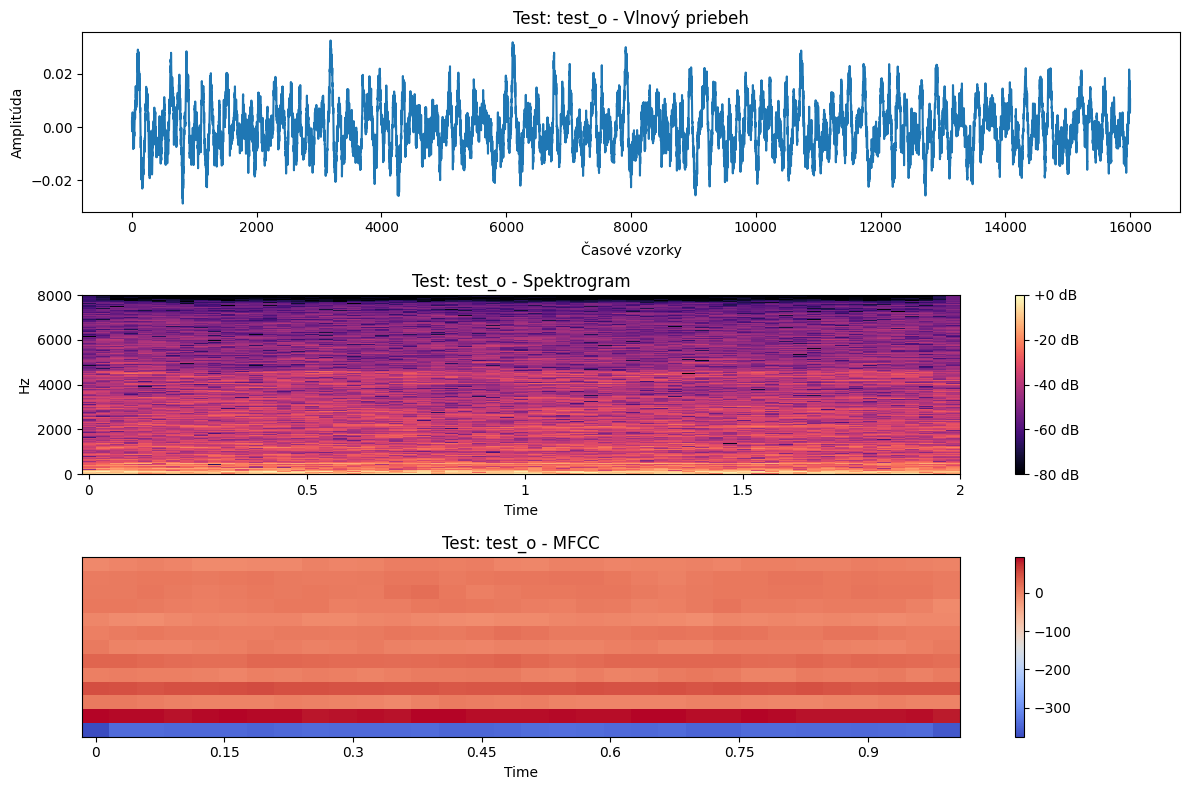

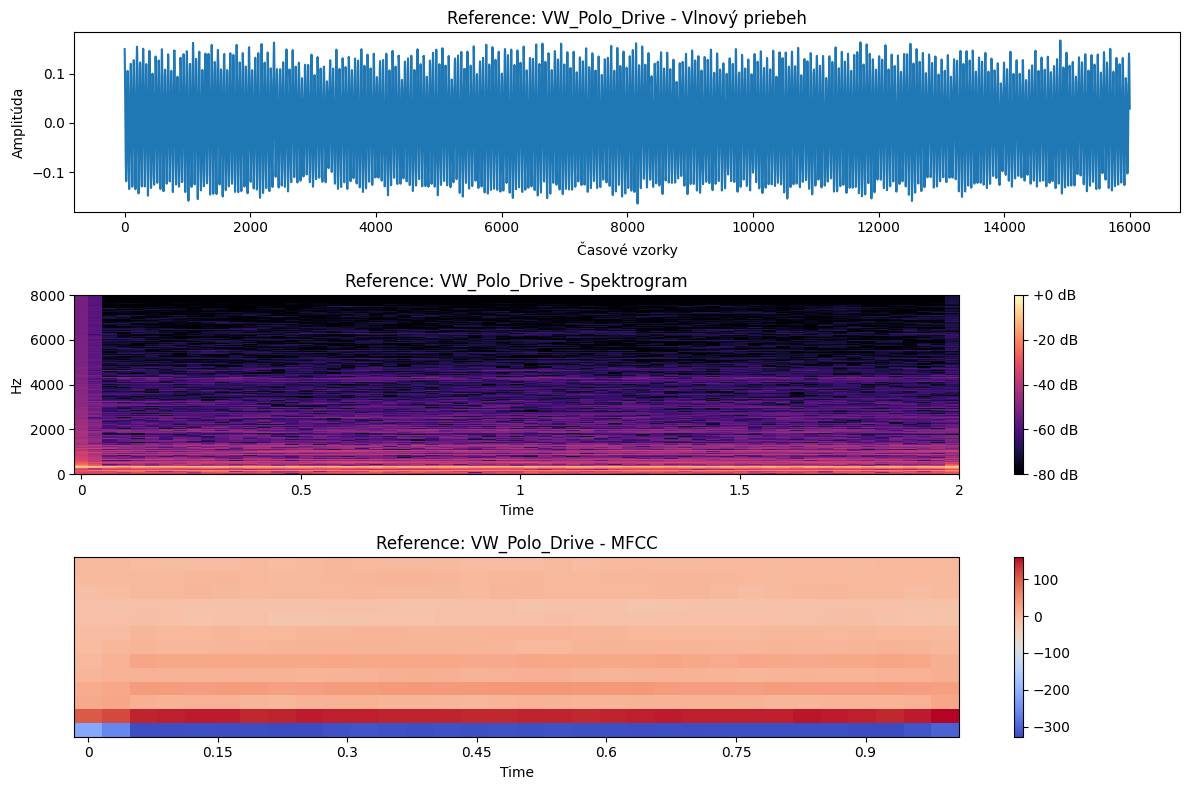

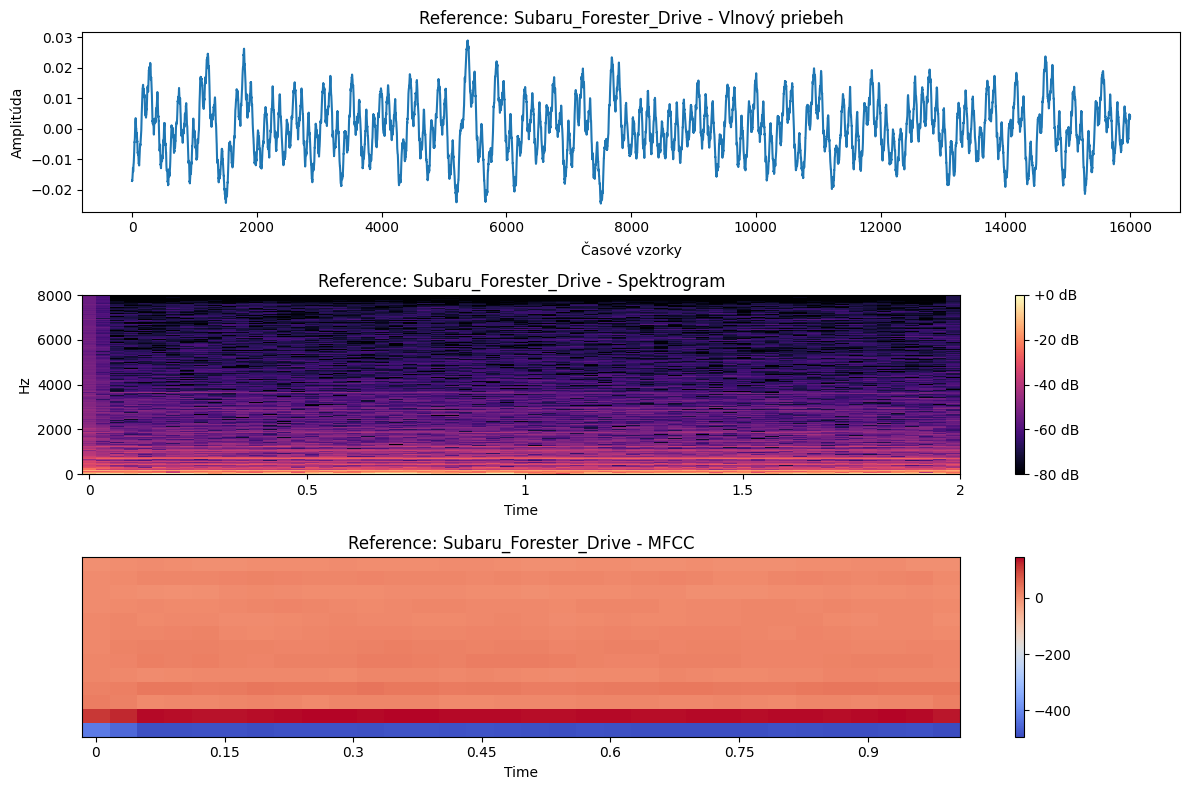

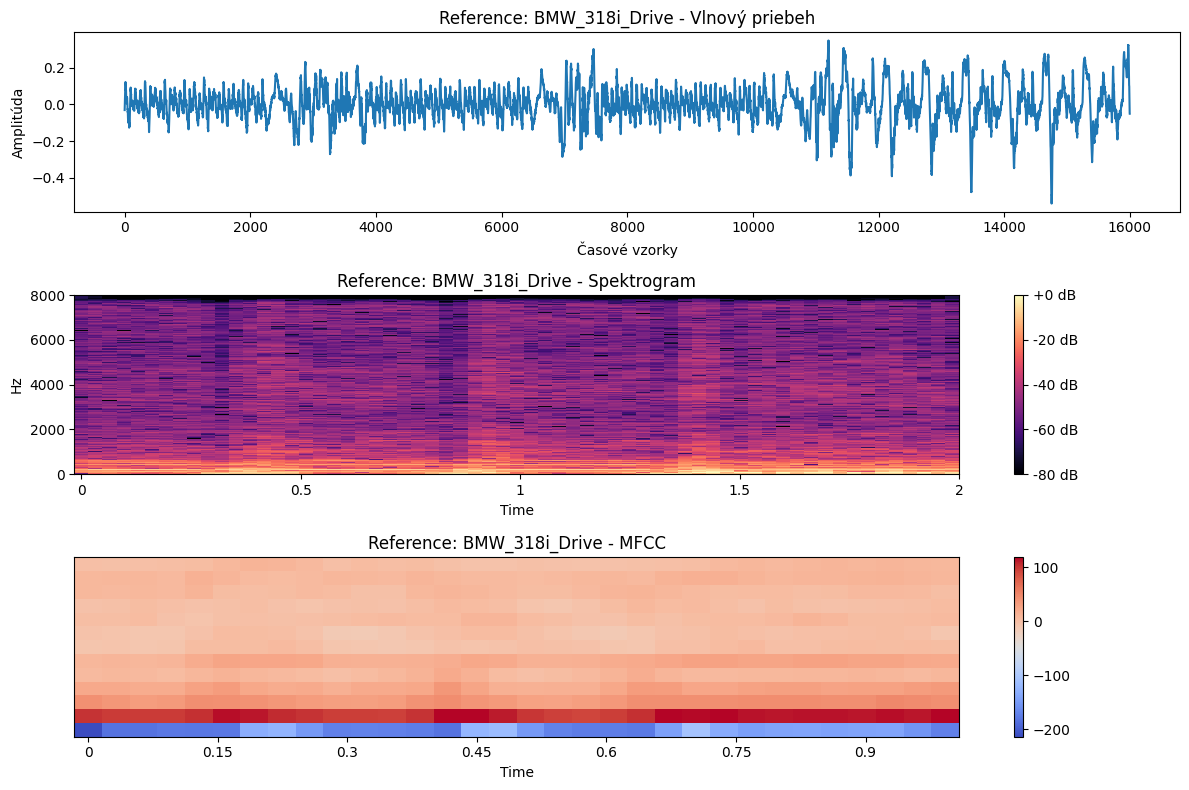

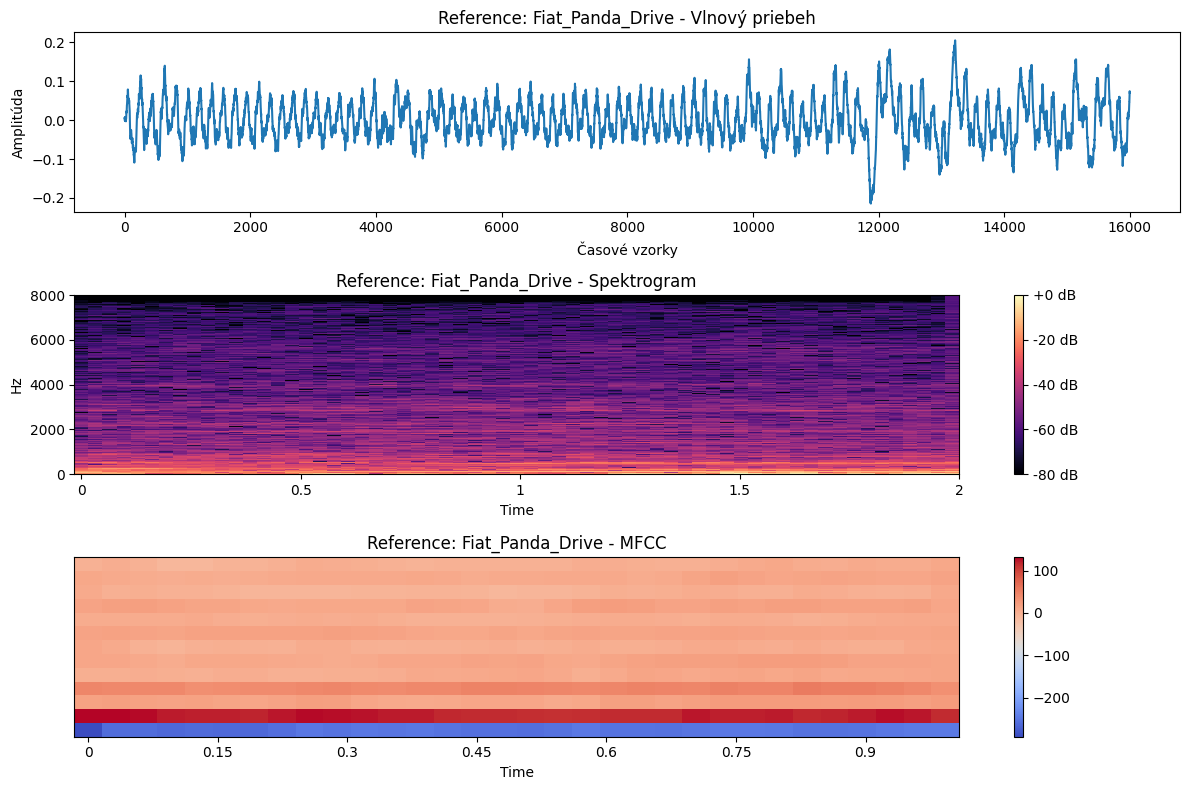

In [ ]:
def plot(signal, sr, title):

    plt.figure(figsize=(12, 8))

    plt.subplot(3,1,1)
    plt.title(f"{title} - Vlnový priebeh")
    plt.xlabel("Časové vzorky")
    plt.ylabel("Amplitúda")
    plt.plot(signal)

    D = np.abs(librosa.stft(signal, n_fft=1024, hop_length=256))
    D_db = librosa.amplitude_to_db(D, ref=np.max)

    plt.subplot(3,1,2)
    plt.title(f"{title} - Spektrogram")
    librosa.display.specshow(D_db, x_axis='time', y_axis='hz', sr=sr)
    plt.colorbar(format="%+2.0f dB")

    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    plt.subplot(3,1,3)
    plt.title(f"{title} - MFCC")
    librosa.display.specshow(mfccs, x_axis='time', sr=sr)
    plt.colorbar()
    plt.tight_layout()
    plt.show()

for signals, labels, group in [(test_signals, test_labels, "Test"), (ref_signals, ref_labels, "Reference")]:
    for sig, label in zip(signals, labels):
        plot(sig, Fs, f"{group}: {label}")

Ako zdroje slúžili prednášky ISS a python notebooky.